In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.34.1


In [3]:
# #Specific site removal (rather than only marsh interior approach)

# excluded_sites = [8, 9]

# df1 = df1[~((df1['Zone'] == 1) & (df1['Site'].isin(excluded_sites)))]

In [4]:
# max(df_final['Plant_Biomass'])

In [5]:
# df_final['Plant_Biomass'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

# #Hist plot
# import seaborn as sn

# g = sn.histplot(data = df_final, x = 'Plant_Biomass', bins = 50)
# g.set(xlabel='Aboveground biomass (g $m^{-2}$)', ylabel='Frequency(count)')
# g

In [6]:
# xre = df[df['Site'] == 10]
# print(xre['Plant_Biomass'].mean())
# print(xre['Plant_Biomass'].median())
# xre['Plant_Biomass']

In [7]:
    
# ##ROUNDING LATITUDE AND LONGITUDE    
# df['lat_r'] = df['Latitude'].round(6)
# df['lon_r'] = df['Longitude'].round(6)


# df['elevation'] = (
#     df
#     .groupby(['lat_r', 'lon_r'])['elevation']
#     .transform('first')
# )

# df.groupby(['lat_r', 'lon_r'])['elevation'].nunique().value_counts()


# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
#     display(df[['Latitude','Longitude','elevation']])


In [8]:
##LOAD PREFORMATTED CSV - BE CAREFUL

df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Pennings/Final_df_interpolated/LOGO_df_interpolated.csv')

df['Sampling_year'] = df['Year']

'''
why overfitting
learn rfs
designing features/feature engineering (rather than just standard scaler)
bucketize features - try with linear regression or non tree model: sklearn.preprocessing.KBinsDiscretizer
data augmentation (complicated)
turn into classification? bucketized output (biomass bucketed into 100 g/m2 or so)
'''

'\nwhy overfitting\nlearn rfs\ndesigning features/feature engineering (rather than just standard scaler)\nbucketize features - try with linear regression or non tree model: sklearn.preprocessing.KBinsDiscretizer\ndata augmentation (complicated)\nturn into classification? bucketized output (biomass bucketed into 100 g/m2 or so)\n'

In [188]:
##FILTERS

df0 = df.copy()
df0['Sampling_year'] = df0['Sampling_year'].astype(str) #Needed after discharge merge

# df0 = df_cleaned2.copy() ##if you want to remove creek points

# df0 = df0[df0['Plant_Biomass'] < 5000] ##If you want to exclude outlier
# df0 = df0[df0['Site'] != 7] ##BE EXTREMELY CAREFUL HERE

'''REMOVE SITE if running all xargs'''


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

seed = 3

'''yargs=df0['Plant_Biomass'] 
'''

##best features


xargs = df0[['evi_max_05_10',
             'slope',
             'elevation',
             'Percent_flooding',
             'srad_peak',
             'dayl_Max',
             'nd_swir2_nir_mean_05_10',
             'ndvi_mean_08_10',
             'nd_r_g_max_05_10',
             'spei14d'
            ]]

import numpy as np

bin_width = 100
max_biomass = 5000 #losing some of the data

bins = np.arange(0, max_biomass + bin_width, bin_width)

# # Define bin edges
# bins_low  = np.arange(0, 1500 + 150, 150)   # 0–1500 by 200
# bins_high = np.arange(2000, 5000 + 750, 750)  # 2000+ by 500

# bins = np.unique(np.concatenate([bins_low, bins_high]))

df0['biomass_bin'] = pd.cut(
    df0['Plant_Biomass'],
    bins=bins,
    labels=False,
    include_lowest=True
)

yargs=df0['biomass_bin'] 

y_bio = df0['Plant_Biomass']

# predictors / target
X = xargs
y = yargs
groups = df0['Site']

# # --- Hold out Site 4 ---
# test_mask = groups == 4

# X_test_final = X.loc[test_mask]
# y_test_final = y.loc[test_mask]

# X_remaining = X.loc[~test_mask]
# y_remaining = y.loc[~test_mask]


# df_test = df0
df_remaining = df0

features = xargs.columns

# # Final test set
# X_test_final = df_test[features]
# y_test_final = df_test['Plant_Biomass']

# Remaining data (for CV + train/val)
X_remaining = df_remaining[features]
y_remaining = yargs
groups_remaining = df_remaining['Site']


print(df0['biomass_bin'].value_counts().sort_index().sum())
# df0['biomass_bin'].value_counts().sort_index()

2938


In [189]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed) ##Play around with n_splits??
train_idx, val_idx = next(gss.split(X_remaining, y_remaining, groups))

X_train = X_remaining.iloc[train_idx]
X_val   = X_remaining.iloc[val_idx]
y_train = y_remaining.iloc[train_idx]
y_val   = y_remaining.iloc[val_idx]

groups_train = groups_remaining.iloc[train_idx]
groups_val = groups_remaining.iloc[val_idx]

groups_val.unique()

# bins

array([6, 5], dtype=int64)

In [190]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline

estimator = RandomForestClassifier(
        n_estimators=500,
        min_samples_split=10,
        min_samples_leaf=25,
        max_depth=7,
        random_state=seed
    )

'''estimator = RandomForestRegressor(
        n_estimators=500,
        min_samples_split=10,
        min_samples_leaf=25,
        max_depth=7,
        random_state=seed
    )'''

# estimator = sklearn.svm.SVR()

# estimator = sklearn.linear_model.LinearRegression()

# estimator = RandomForestRegressor(
#         n_estimators=100,
#         min_samples_split=2,
#         min_samples_leaf=1,
#         max_depth=3,
#         random_state=seed
#     )

# estimator = sklearn.ensemble.GradientBoostingRegressor()

# estimator = sklearn.neighbors.KNeighborsRegressor()

# estimator = sklearn.linear_model.Ridge()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('forest', estimator)
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('forest',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=25,
                                        min_samples_split=10, n_estimators=500,
                                        random_state=3))])

In [191]:
y_val_pred = pipe.predict(X_val)

print('Validation R²:', metrics.r2_score(y_val, y_val_pred))
print('Validation RMSE:', np.sqrt(metrics.mean_squared_error(y_val, y_val_pred)))

Validation R²: -0.12390201215449959
Validation RMSE: 7.077574689967142


In [192]:
# y_test_pred = pipe.predict(X_test_final)

# print('TEST (Site 4) R²:', metrics.r2_score(y_test_final, y_test_pred))
# print('TEST RMSE:', np.sqrt(metrics.mean_squared_error(y_test_final, y_test_pred)))
# print('TEST NRMSE:',
#       np.sqrt(metrics.mean_squared_error(y_test_final, y_test_pred)) /
#       np.ptp(y_test_final))

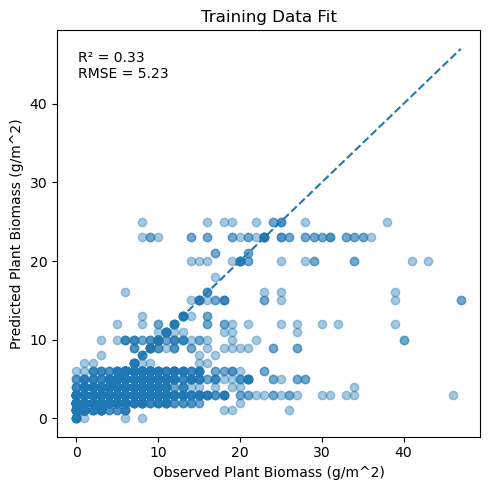

In [193]:
y_train_pred = pipe.predict(X_train)

from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_train, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_train_pred, alpha=0.4)
plt.plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    linestyle='--'
)

plt.text(
    0.05, 0.95,
    f'R² = {r2:.2f}\nRMSE = {rmse:.2f}',
    transform=plt.gca().transAxes,
    verticalalignment='top'
)

plt.xlabel('Observed Plant Biomass (g/m^2)')
plt.ylabel('Predicted Plant Biomass (g/m^2)')
plt.title('Training Data Fit')
plt.tight_layout()
plt.show()

In [194]:
# pipe_scale = Pipeline([
#         ('scaler', StandardScaler())
#     ])

# psft = pipe_scale.fit_transform(X_remaining)

# for idx in range(len(X_remaining.columns)):
#     colname = X_remaining.columns[idx]
#     vals = psft[:,idx]
#     plt.figure()
#     print(colname)
#     plt.hist(vals)

y_remaining

0       4
1       4
2       1
3       1
4       4
       ..
2933    4
2934    3
2935    3
2936    2
2937    2
Name: biomass_bin, Length: 2938, dtype: int64

In [195]:
from sklearn.model_selection import GroupKFold, cross_validate
from scipy.stats import pearsonr

gkf = GroupKFold(n_splits=10)

kf_groups = groups

# kf_groups= kf_groups.sample(frac = 1) ##borscht

train_rmses = []
val_rmses = []
pearsons = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_remaining, y_remaining, kf_groups)):
    
    train_groups = kf_groups.iloc[train_idx]
    val_groups = kf_groups.iloc[val_idx]
    
    train_x = X.iloc[train_idx]
    train_y = y.iloc[train_idx]
    train_y_bio = y_bio.iloc[train_idx]
    
    val_x = X.iloc[val_idx]
    val_y = y.iloc[val_idx]
    val_y_bio = y_bio.iloc[val_idx]

    print(f"\nFold {fold}:")
    print(f"\tTraining groups: {((train_groups)).unique()}")
    print(f"\tValidation groups: {((val_groups)).unique()}")
    
    estimator = RandomForestClassifier( ##TRY: n_est 500, minsplit 10, minleaf 25, max depth 7 or even 10  (mayyybe 500 5 10 5)
        n_estimators=500,
        min_samples_split=10,
        min_samples_leaf=25,
        max_depth=7,
        random_state=seed
    )
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', estimator)
    ])

    pipe.fit(train_x, train_y)
    
    train_pred_y = pipe.predict(train_x)
    val_pred_y = pipe.predict(val_x)

    train_pred_y = [bins[x] for x in train_pred_y]
    val_pred_y = [bins[x] for x in val_pred_y]
    
    train_rmse = np.sqrt(metrics.mean_squared_error(train_pred_y, train_y_bio))
    val_rmse = np.sqrt(metrics.mean_squared_error(val_pred_y, val_y_bio))
    
    r_pears, p_value = pearsonr(val_y_bio, val_pred_y)
    
    print('\ttrain rmse:\t{:.2f}'.format(train_rmse))
    print('\tval rmse:\t{:.2f}'.format(val_rmse))
    print(f"\tPearson r: {r_pears:.2f}, p-value: {p_value:.3f}")

    
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
    pearsons.append(r_pears)
    

print('***')
print('mean train rmse:\t{:.2f}'.format(np.mean(train_rmses)))
print('mean val rmse:\t{:.2f}'.format(np.mean(val_rmses)))
print('mean pearson r:\t{:.2f}'.format(np.mean(pearsons)))


Fold 0:
	Training groups: [8 7 9 6 5 4 3 2 1]
	Validation groups: [10]
	train rmse:	586.02
	val rmse:	394.39
	Pearson r: 0.21, p-value: 0.000

Fold 1:
	Training groups: [ 8  7  9  6  5  4 10  3  1]
	Validation groups: [2]
	train rmse:	544.74
	val rmse:	702.95
	Pearson r: 0.30, p-value: 0.000

Fold 2:
	Training groups: [ 8  7  9  5  4 10  3  2  1]
	Validation groups: [6]
	train rmse:	559.41
	val rmse:	669.93
	Pearson r: 0.46, p-value: 0.000

Fold 3:
	Training groups: [ 8  9  6  5  4 10  3  2  1]
	Validation groups: [7]
	train rmse:	520.25
	val rmse:	1356.10
	Pearson r: 0.26, p-value: 0.000

Fold 4:
	Training groups: [ 8  7  9  6  5  4 10  2  1]
	Validation groups: [3]
	train rmse:	568.57
	val rmse:	392.28
	Pearson r: 0.41, p-value: 0.000

Fold 5:
	Training groups: [ 8  7  9  6  5 10  3  2  1]
	Validation groups: [4]
	train rmse:	577.77
	val rmse:	423.35
	Pearson r: 0.48, p-value: 0.000

Fold 6:
	Training groups: [ 8  7  9  6  4 10  3  2  1]
	Validation groups: [5]
	train rmse:	554.28
	

In [196]:
from sklearn.model_selection import GroupKFold, cross_validate

from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
import numpy as np

gkf = GroupKFold(n_splits=10)

cv_results = cross_validate(
    pipe,
    X_remaining,
    y_remaining,
    cv=gkf,
    groups=groups,
    scoring=('r2', 'neg_root_mean_squared_error'),
    return_train_score=True
)

cv_results

#Feature importance and average RMSE
xyz = pd.DataFrame(cv_results)
# print('testing r2: ' + str(xyz['test_r2'].mean()))
# print('testing rmse: ' + str(xyz['test_neg_root_mean_squared_error'].mean()))

# print('training r2: ' + str(xyz['train_r2'].mean()))
# print('training rmse: ' + str(xyz['train_neg_root_mean_squared_error'].mean()))


# print('testing NRMSE is: ' + str(xyz['test_neg_root_mean_squared_error'].mean()/np.ptp(y_val)))

# print(cv_results)

xyz

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,1.276940,0.021558,-0.312693,0.310062,-3.760891,-5.642481
1,1.283206,0.021555,-0.241993,0.351518,-6.771295,-5.239912
2,1.258930,0.025541,-0.098681,0.312296,-6.442968,-5.378733
3,1.237436,0.018283,-1.116471,0.046080,-13.211031,-4.976510
4,1.275322,0.027570,0.086626,0.328420,-3.765213,-5.459464
5,1.267436,0.020062,-0.010157,0.302955,-3.976567,-5.558732
6,1.306471,0.021792,-0.165224,0.302343,-7.693842,-5.324965
7,1.290552,0.020050,0.080924,0.326695,-4.215987,-5.423901
8,1.315457,0.018046,-0.459170,0.334028,-5.211002,-5.386053
9,1.364959,0.016039,-0.102436,0.313762,-3.801528,-5.396901


In [160]:
print('train rmse: {:.2f}'.format(-1*xyz['train_neg_root_mean_squared_error'].mean()))
print('test rmse: {:.2f}'.format(-1*xyz['test_neg_root_mean_squared_error'].mean()))

print('train r2: {:.2f}'.format(xyz['train_r2'].mean()))
print('test r2: {:.2f}'.format(xyz['test_r2'].mean()))

train rmse: 10.90
test rmse: 11.72
train r2: 0.27
test r2: -0.23


In [161]:
# from sklearn.model_selection import GroupKFold
# import pandas as pd
# import numpy as np

# gkf = GroupKFold(n_splits=9)

# groups_remaining = groups.loc[~test_mask]

# feature_names = X_remaining.columns
# importances = []

# for fold, (train_idx, val_idx) in enumerate(
#         gkf.split(X_remaining, y_remaining, groups_remaining)):

#     X_tr = X_remaining.iloc[train_idx]
#     y_tr = y_remaining.iloc[train_idx]

#     pipe.fit(X_tr, y_tr)

#     rf = pipe.named_steps['forest']
#     importances.append(rf.feature_importances_)

# importances = pd.DataFrame(
#     importances,
#     columns=feature_names,
#     index=[f'fold_{i}' for i in range(len(importances))]
# )


In [162]:
# importance_summary = pd.DataFrame({
#     'mean_importance': importances.mean(),
#     'std_importance': importances.std(),
#     'cv_importance': importances.std() / importances.mean()
# }).sort_values('mean_importance', ascending=False)


In [118]:
# importance_summary.head(21)

In [119]:
# from sklearn.model_selection import GroupKFold, RandomizedSearchCV

# gkf = GroupKFold(n_splits=9)

# param_grid = {
#     'forest__n_estimators': [50, 100, 200, 300, 500, 1000],
#     'forest__max_depth': [10, 20, 30, None],
#     'forest__min_samples_split': [2, 5, 10],
#     'forest__min_samples_leaf': [1, 2, 4]
# }

# rf_search = RandomizedSearchCV(
#     estimator=pipe,
#     param_distributions=param_grid,
#     n_iter=50,
#     cv=gkf,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     random_state=seed
# )

# rf_search.fit(
#     X_remaining,
#     y_remaining,
#     groups=groups_remaining
# )

# best_pipe = rf_search.best_estimator_


In [120]:
# # y_test_pred = best_pipe.predict(X_test_final)
# y_test_pred = pipe.predict(X_test_final)

# print("TEST R²:", metrics.r2_score(y_test_final, y_test_pred))
# print("TEST RMSE:", np.sqrt(metrics.mean_squared_error(y_test_final, y_test_pred)))


In [121]:
# best_pipe  #max depth 10, min samples leaf 4, n estimators 200, random state 3

In [122]:
# ##Looping through sites
# seed = 3

# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('forest', RandomForestRegressor(
#         n_estimators=200,
#         min_samples_split=5,
#         min_samples_leaf=4,
#         max_depth=5,
#         random_state=seed,
#         n_jobs=-1
#     ))
# ])

# results = []
# importances = []

# feature_names = X.columns
sites=groups ##Added, from earlier

unique_sites = np.sort(sites.unique())

# for site in unique_sites:

#     # --- Split ---
#     train_mask = sites != site
#     test_mask  = sites == site

#     X_train = X.loc[train_mask]
#     y_train = y.loc[train_mask]

#     X_test  = X.loc[test_mask]
#     y_test  = y.loc[test_mask]

#     # --- Fit ---
#     pipe.fit(X_train, y_train)

#     # --- Predict ---
#     y_pred = pipe.predict(X_test)

#     # --- Metrics ---
#     r2   = metrics.r2_score(y_test, y_pred)
#     rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#     nrmse = rmse / np.ptp(y_test)

#     results.append({
#         'site': site,
#         'n_samples': len(y_test),
#         'r2': r2,
#         'rmse': rmse,
#         'nrmse': nrmse
#     })

#     # --- Feature importance ---
#     rf = pipe.named_steps['forest']
#     importances.append(rf.feature_importances_)
    
# results_df = pd.DataFrame(results)
# results_df.sort_values('r2')

# importances_df = pd.DataFrame(
#     importances,
#     columns=feature_names,
#     index=results_df['site']
# )


# importance_summary = pd.DataFrame({
#     'mean_importance': importances_df.mean(),
#     'std_importance': importances_df.std(),
#     'cv_importance': importances_df.std() / importances_df.mean()
# }).sort_values('mean_importance', ascending=False)


# print(importance_summary.head(21))

# results_df[['site', 'r2', 'rmse']].sort_values('r2')
# results_df.plot.scatter('n_samples', 'r2')
# y.groupby(sites).var()


In [123]:
# results_df.plot.scatter('n_samples', 'rmse')
# results_df[['site', 'r2', 'rmse']].sort_values('rmse')

In [124]:
# import matplotlib.pyplot as plt
# import numpy as np

# plt.figure(figsize=(5, 5))
# plt.scatter(y_test_final, y_test_pred, alpha=0.6)
# plt.plot(
#     [y_test_final.min(), y_test_final.max()],
#     [y_test_final.min(), y_test_final.max()],
#     linestyle='--'
# )

# plt.xlabel("Observed Biomass")
# plt.ylabel("Predicted Biomass")
# plt.title("Observed vs Predicted — Test Site (Site 4)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [125]:
all_preds = []

for site in unique_sites:

    train_mask = sites != site
    test_mask  = sites == site

    X_train = X.loc[train_mask]
    y_train = y.loc[train_mask]
    X_test  = X.loc[test_mask]
    y_test  = y.loc[test_mask]

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    tmp = pd.DataFrame({
        'site': site,
        'observed': y_test.values,
        'predicted': y_pred
    })

    all_preds.append(tmp)

pred_df = pd.concat(all_preds, ignore_index=True)


C:\Users\arj26323\.conda\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\arj26323\.conda\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\arj26323\.conda\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\arj26323\.conda\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

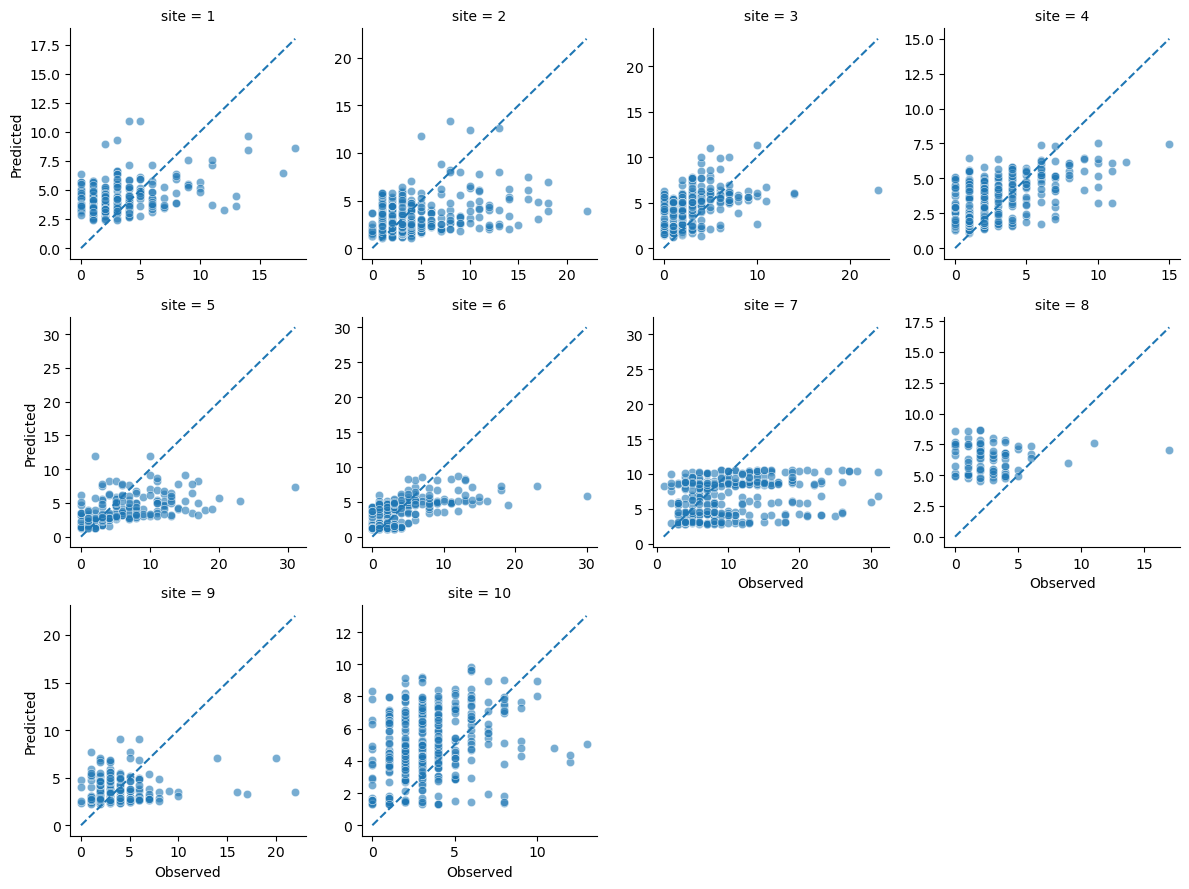

In [126]:
import seaborn as sns

g = sns.FacetGrid(pred_df, col="site", col_wrap=4, height=3, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="observed", y="predicted", alpha=0.6)
g.map_dataframe(
    lambda data, **kws: plt.plot(
        [data.observed.min(), data.observed.max()],
        [data.observed.min(), data.observed.max()],
        linestyle='--'
    )
)

g.set_axis_labels("Observed", "Predicted")
g.tight_layout()
plt.show()


In [127]:
combined_r2 = metrics.r2_score(pred_df['observed'], pred_df['predicted'])
combined_rmse = np.sqrt(metrics.mean_squared_error(
    pred_df['observed'], pred_df['predicted']
))


print(combined_r2)
print(combined_rmse)

0.20274483625850315
3.8533398595247723


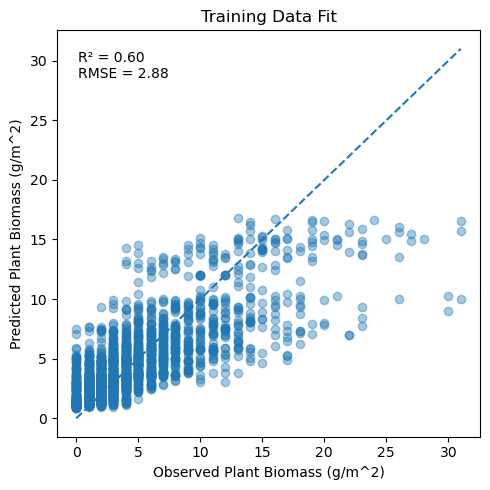

In [128]:
y_train_pred = pipe.predict(X_train)

from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_train, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_train_pred, alpha=0.4)
plt.plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    linestyle='--'
)

plt.text(
    0.05, 0.95,
    f'R² = {r2:.2f}\nRMSE = {rmse:.2f}',
    transform=plt.gca().transAxes,
    verticalalignment='top'
)

plt.xlabel('Observed Plant Biomass (g/m^2)')
plt.ylabel('Predicted Plant Biomass (g/m^2)')
plt.title('Training Data Fit')
plt.tight_layout()
plt.show()

In [129]:
corr = X.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = [c for c in upper.columns if any(upper[c] > 0.9)]
X_reduced = X.drop(columns=to_drop)


X_reduced

,evi_max_05_10,slope,elevation,Percent_flooding,srad_peak,dayl_Max,nd_swir2_nir_mean_05_10,ndvi_mean_08_10,nd_r_g_max_05_10,spei14d
0,0.232282,0.693467,1.179146,0.014085,336.610535,50542.17969,-0.404771,0.608544,0.059350,0.119041
1,0.190468,0.693467,1.179146,0.014085,316.011963,50542.17969,-0.317078,0.502339,0.117821,0.104658
2,0.195634,0.693467,1.179146,0.014085,332.383911,50542.17969,-0.336010,0.548571,0.075218,-0.249589
3,0.178204,0.693467,1.179146,0.014085,330.674133,50542.17969,-0.277814,0.497044,0.065727,0.230000
4,0.191262,0.693467,1.179146,0.014085,334.421417,50542.17969,-0.281224,0.496204,0.076267,0.237534
...,...,...,...,...,...,...,...,...,...,...
2933,0.168836,0.308225,1.087664,0.011594,340.065857,50610.12891,-0.262571,0.539582,0.074512,0.224795
2934,0.132574,0.308225,1.087664,0.011594,327.975342,50610.12891,-0.203389,0.453920,0.056916,-0.282676
2935,0.200399,0.308225,1.087664,0.011594,311.941528,50610.12891,-0.307148,0.572171,0.047406,0.063571
2936,0.204570,0.308225,1.087664,0.011594,336.644226,50610.12891,-0.348148,0.566227,0.073944,0.069726


In [130]:
print(len(yargs))

##More work to do
# feature_importance_df

# ##Export csv dataframe
# out_dir = os.path.expanduser('C:/Users/arj26323/Documents/Data/Biomass datasets/Combined_GA_VA')
# out_csv = os.path.join(out_dir, 'ga_2025.csv')
# df0.to_csv(out_csv, index = False)

2938


KeyError: 'nd_swir2_nir_mean_01_12'

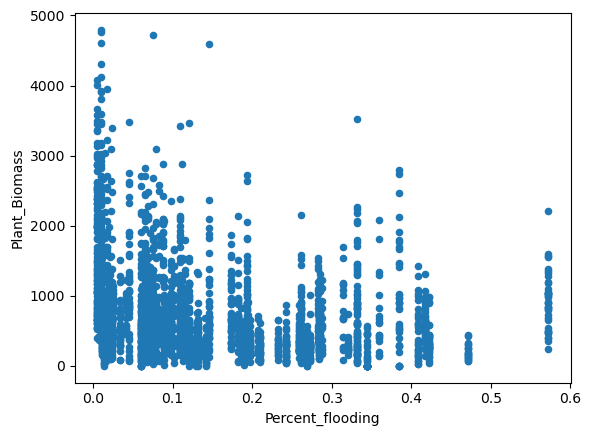

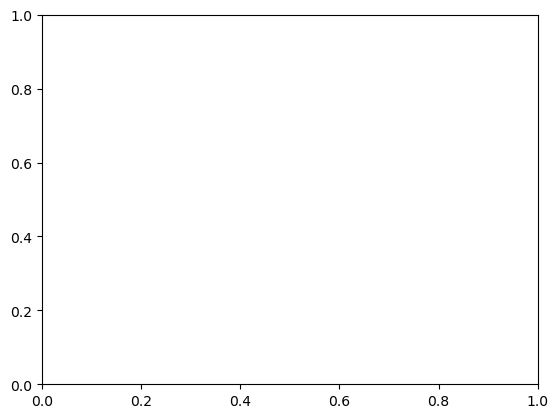

In [131]:
g = df0.plot(kind = 'scatter', x = 'Percent_flooding', y = 'Plant_Biomass')
g = df0.plot(kind = 'scatter', x = 'nd_swir2_nir_mean_01_12', y = 'Plant_Biomass')
g = df0.plot(kind = 'scatter', x = 'flats_min_03_05', y = 'Plant_Biomass')
g = df0.plot(kind = 'scatter', x = 'elevation', y = 'Plant_Biomass')
g = df0.plot(kind = 'scatter', x = 'evi_max_05_10', y = 'Plant_Biomass')

g

In [ ]:
import matplotlib.pyplot as plt
residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# plt.scatter(yargs_test, y_pred)
# plt.xlabel("Actual Biomass")
# plt.ylabel("Predicted Biomass")
# plt.plot([min(yargs_test), max(yargs_test)], [min(yargs_test), max(yargs_test)], 'r--')
# plt.show()

In [ ]:
import os
# os.chdir('C:\\Users\\arj26323\\Documents\\Data')
# os.getcwd()

# from joblib import dump

# # Save the whole pipeline (including preprocessing and model)
# dump(pipe, 'rf_pipeline.joblib')

In [ ]:
#Finito